# ABOVE AC9 Data Processing  

## Checking Sample Replicates

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson

**Last Updated:** September 7th, 2018

### Import libraries

In [3]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec

### Functions

** Accepts a dictionary where the keys are the rep names (to be displayed on the legend), with the sample type (filtered or raw) as the first part of a space-separated string (which might also include rep number and/or date) and the entries are the file paths to the data to be plotted **

(this is so that linestyle type can be changed based on whether the sample is filtered or raw)

Example entry in dictionary: 'fil 2 091718': filepath

In [278]:
def plotting_multiple_files(dict_of_files, title='Title'):
    linestyles = {'fil':'--','raw':'-'}
    for reps in sorted(list(dict_of_files)):
        Sample_Type = reps.split(' ')[0]
        df = pd.read_csv(dict_of_files[reps], skiprows = 0, delimiter= '\t')
        df.reset_index(inplace=True, drop=False)
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        plt.plot('wl','mean',data=df,label=j,linestyle=linestyles[Sample_Type])
        plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
    plt.ylabel('[1/m]')
    plt.xlabel('Wavelength (nm)')
    plt.title(title)
    plt.legend(sorted(list(dict_of_files)))
    return plt

## Inputs

In [16]:
parent_directory = os.path.abspath('..')
replicate_directory_name = '2_2_summary_stats_cleaned_MANUAL'
averaged_files_name = '3_1_averaged_summary_stats'

replicate_files_location = parent_directory+'/Data/'+replicate_directory_name
averaged_files_location = parent_directory+'/Data/'+averaged_files_name

### Upload metadata file with filepaths

In [17]:
metadata_updated = pd.read_csv('../Metadata/project_metadata_updated.csv', dtype={'Date': object, 'Rep':object}, skiprows=0, delimiter= '\t')

Samples for most sites were taken on one date, but some were taken on multiple dates. In which case there may be multiple 'rep 1's or 'rep 2's for the same site. The following code creates a list 'need_date' which specifies the sites where 'date' should be included to distinguish multiple reps.

In [212]:
## Creates a pandas 'series' object where the index is sites 
##and the data is the number of unique dates associated with that site
group = metadata_updated[metadata_updated['Sample_Type']!='cal'].groupby('Site')
df2 = group.apply(lambda x: len(x['Date'].unique()))

## Checks if a site has more than one unique date associated with it
## and if so, adds it to the 'need_date' list
need_date = []
for i in df2.index:
    if df2[i] > 1:
        need_date.append(i)
need_date

['cbr', 'y17', 'y20']

#### Create an empty nested dictionary to store file paths in the correct organization for plotting. Keys are site names. Entries are nested dictionaries: level 1 is attenuation or absorption, level 2 is keys: rep names (including date where applicable) and entries: file paths. Sites where there are only calibration measurements are excluded.

In [223]:
x = {}
for j in set(metadata_updated[metadata_updated['Sample_Type']!='cal']['Site']):
    x[j] = {'a':{}, 'c':{}}

#### Filling the dictionary with rep names and file paths.

In [224]:
## Iterate through the metadata dataframe; two ways to call: the row in general or the index
for index, row in metadata_updated.iterrows():
    ## Only include files/reps that passed manual removal
    if row['Pass_Manual_Removal'] == 'pass':
        ## Do not include 'calibration' samples (at least for now)
        if row['Sample_Type'] == 'cal':
            continue
        else:
            site = row['Site']
            analysis_type = row['Analysis_Type']
            filepath = row['Summary_file_path_cleaned_MANUAL']
            ## Define rep name by checking if this site has multiple dates
            if site in need_date:
                ## if so, include date in repname
                repname = row['Sample_Type']+' '+row['Rep']+' '+row['Date']
            else:
                repname = row['Sample_Type']+' '+row['Rep']
            ## Once rep name is established, create new dictionary entry
            ## with rep name as key and filepath as entry
            x[site][analysis_type][repname] = filepath

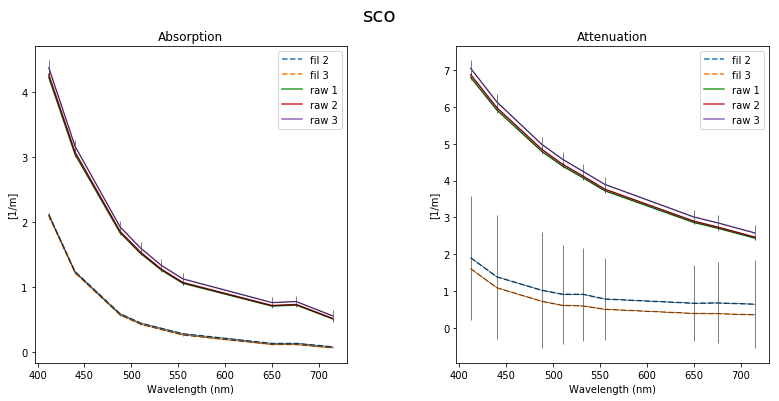

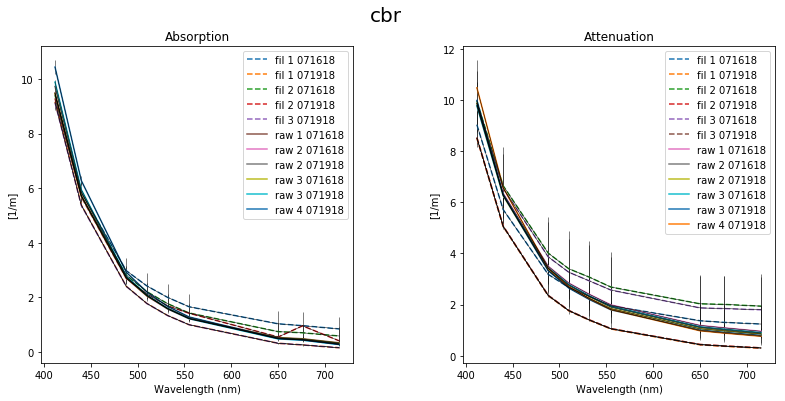

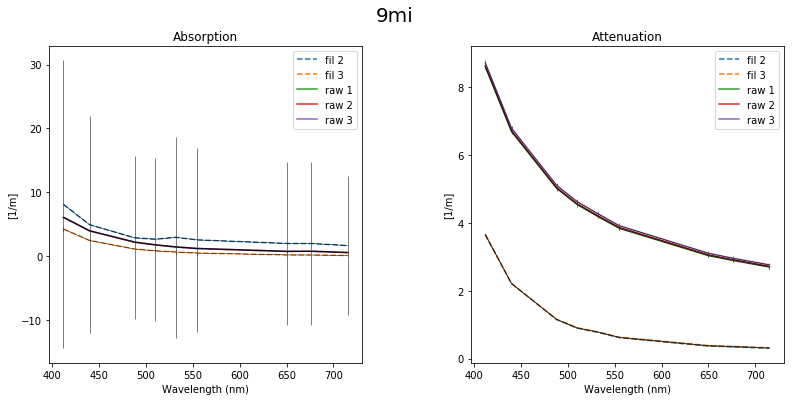

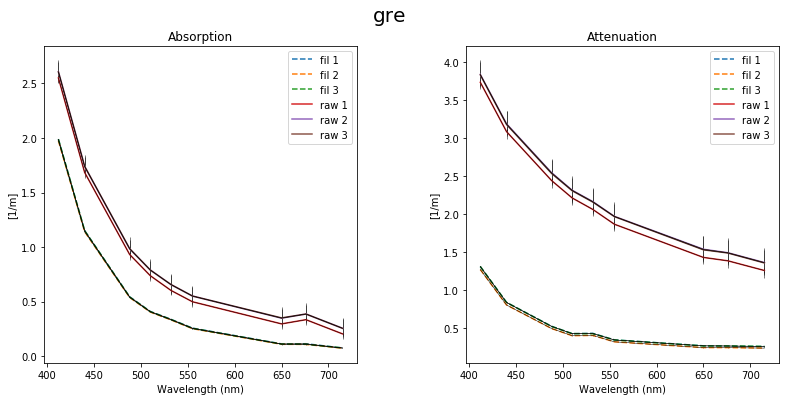

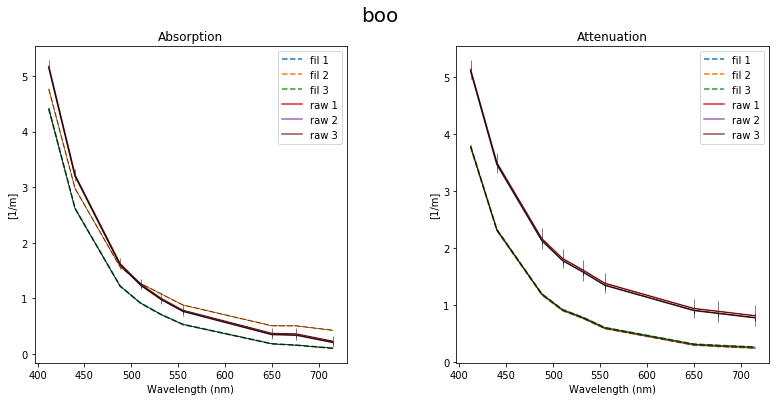

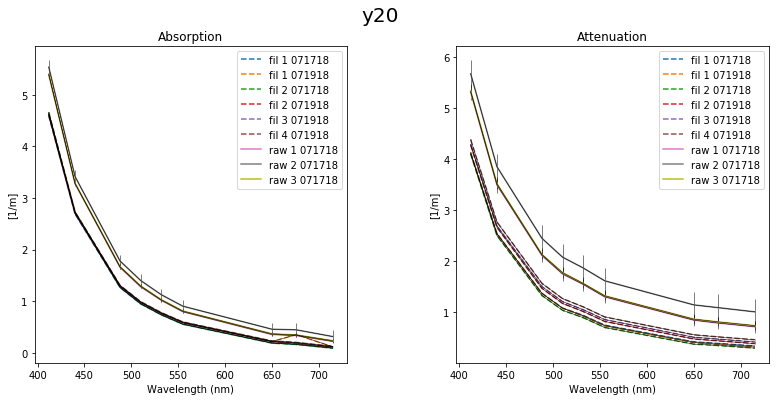

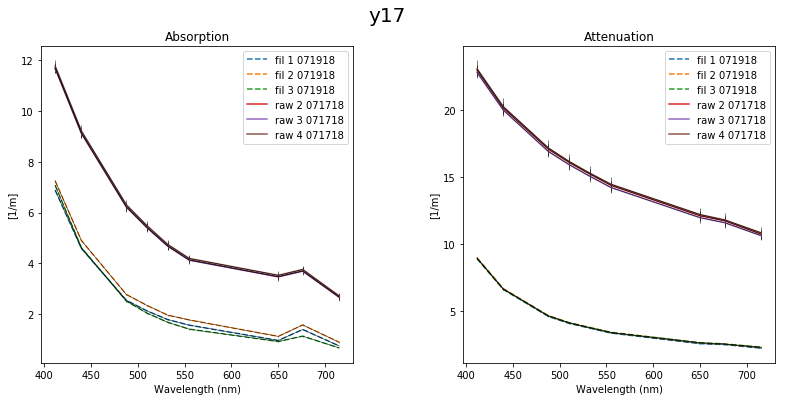

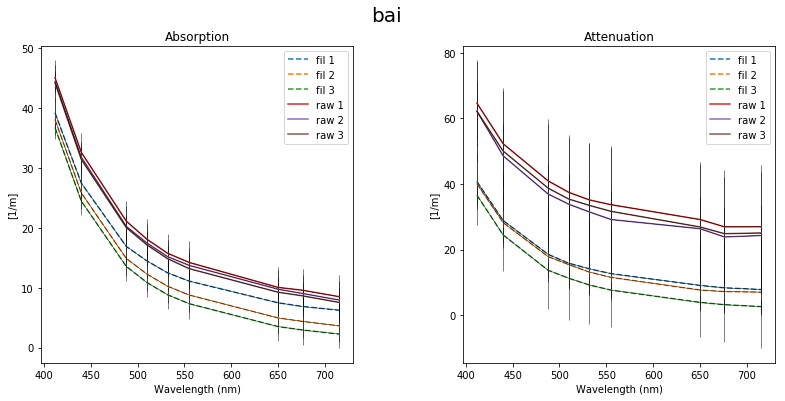

In [279]:
for i in x:
    absorption = x[i]['a']
    attenuation = x[i]['c']
    plt.subplots(1, 2, figsize=(12, 5.5))
    plt.subplot(1, 2, 1)
    absorption_graph = plotting_multiple_files(absorption, title='Absorption')
    plt.subplot(1, 2, 2)
    attenuation_graph = plotting_multiple_files(attenuation, title='Attenuation')
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle(i, fontsize=20)
    plt.show()

In [272]:
dict_for_sites_with_multiple_dates = {}
for j in need_date:
    for k in set(metadata_updated[metadata_updated['Site']==j]['Date']):
        dict_for_sites_with_multiple_dates[j+'_'+k] = {'a':{}, 'c':{}}
dict_for_sites_with_multiple_dates

{'cbr_071618': {'a': {}, 'c': {}},
 'cbr_071918': {'a': {}, 'c': {}},
 'y17_071718': {'a': {}, 'c': {}},
 'y17_071918': {'a': {}, 'c': {}},
 'y20_071718': {'a': {}, 'c': {}},
 'y20_071918': {'a': {}, 'c': {}}}

In [273]:
## Iterate through the metadata dataframe; two ways to call: the row in general or the index
for index, row in metadata_updated.iterrows():
    sitedate = row['Site']+'_'+row['Date']
    ## This is only for sites in our new dictionary
    if sitedate not in dict_for_sites_with_multiple_dates:
        continue
    ## Only include files/reps that passed manual removal
    if row['Pass_Manual_Removal'] == 'pass':
        ## Do not include 'calibration' samples (at least for now)
        if row['Sample_Type'] == 'cal':
            continue
        else:
            analysis_type = row['Analysis_Type']
            filepath = row['Summary_file_path_cleaned_MANUAL']
            repname = row['Sample_Type']+' '+row['Rep']
            ## Once rep name is established, create new dictionary entry
            ## with rep name as key and filepath as entry
            dict_for_sites_with_multiple_dates[sitedate][analysis_type][repname] = filepath

In [276]:
for i in sorted(dict_for_sites_with_multiple_dates):
    print i

cbr_071618
cbr_071918
y17_071718
y17_071918
y20_071718
y20_071918


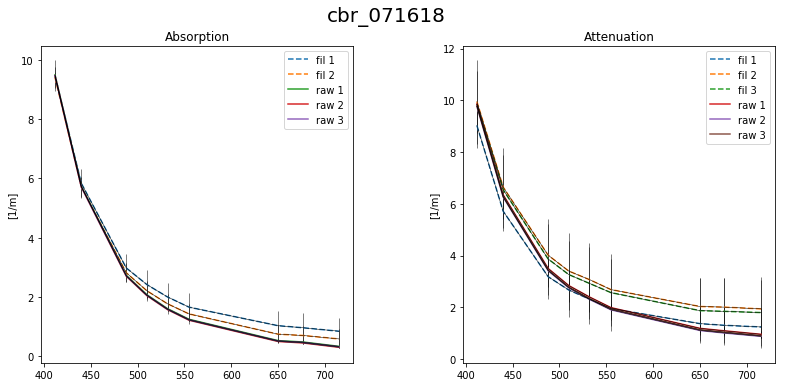

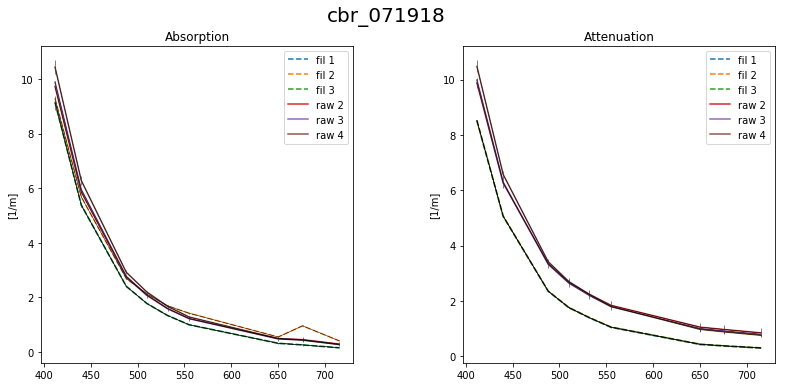

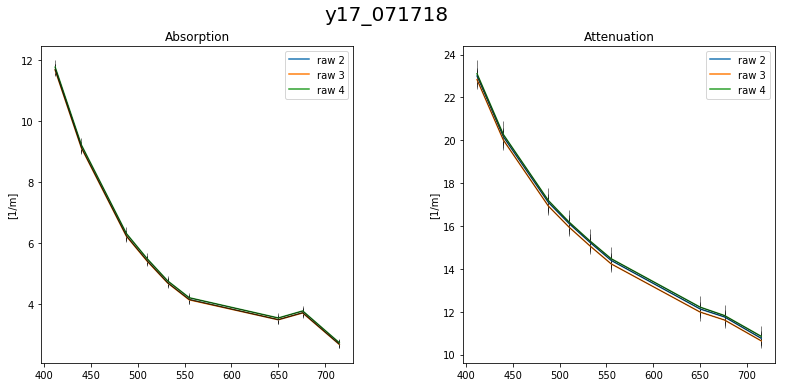

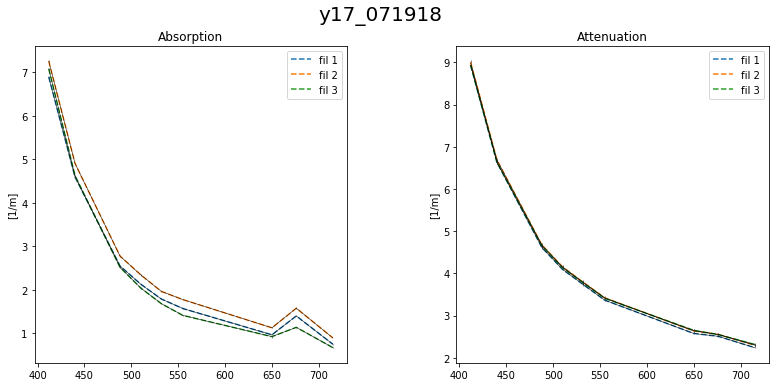

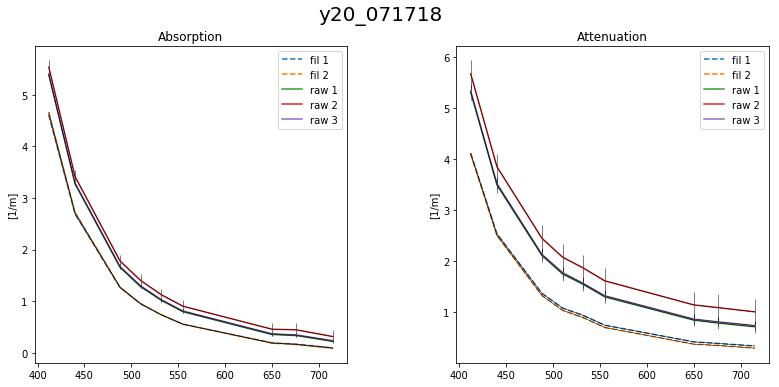

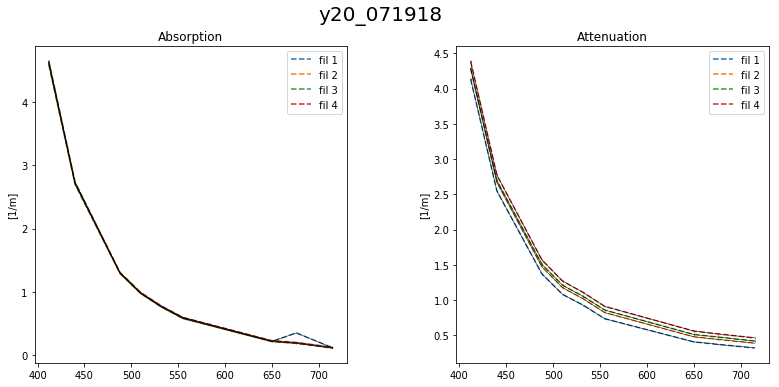

In [277]:
for i in sorted(dict_for_sites_with_multiple_dates):
    absorption = dict_for_sites_with_multiple_dates[i]['a']
    attenuation = dict_for_sites_with_multiple_dates[i]['c']
    plt.subplots(1, 2, figsize=(12, 5.5))
    plt.subplot(1, 2, 1)
    absorption_graph = plotting_multiple_files(absorption, title='Absorption')
    plt.subplot(1, 2, 2)
    attenuation_graph = plotting_multiple_files(attenuation, title='Attenuation')
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle(i, fontsize=20)
    plt.show()

In [264]:
## Only include files/reps that passed manual removal

In [256]:
for i in set(metadata_updated[metadata_updated['Site']=='y20']['Date']):
    print i

071918
071718


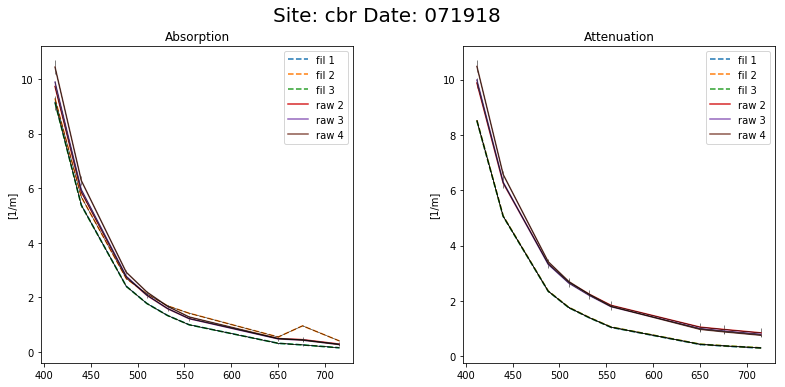

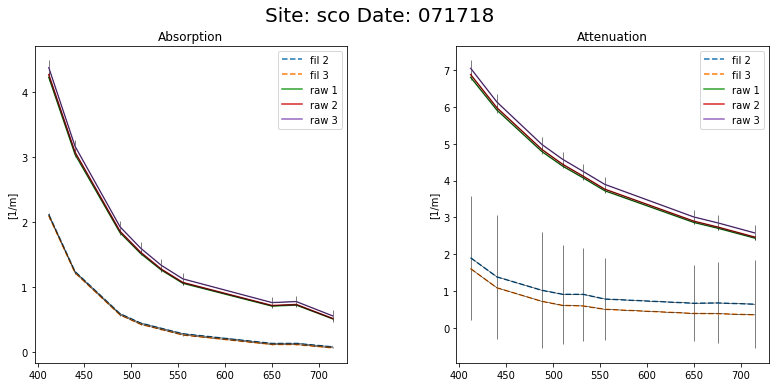

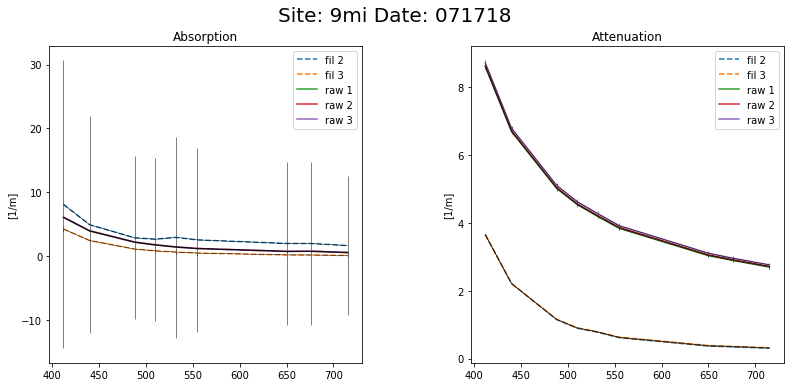

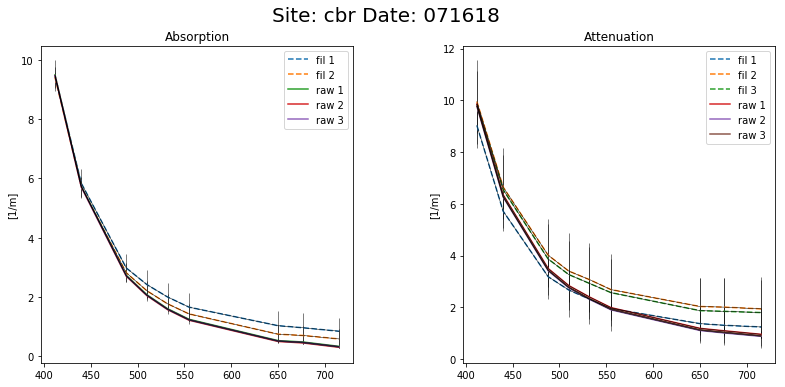

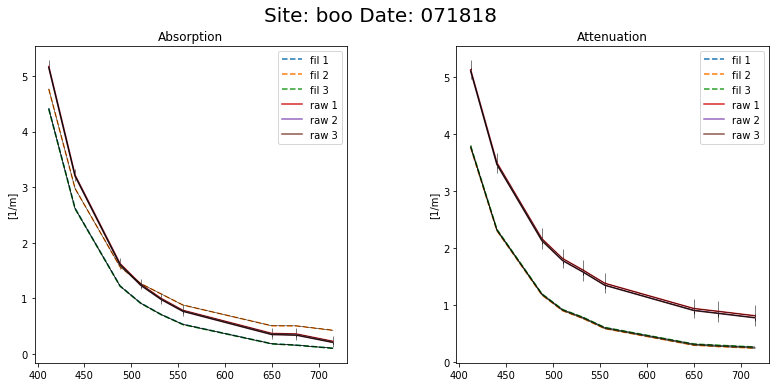

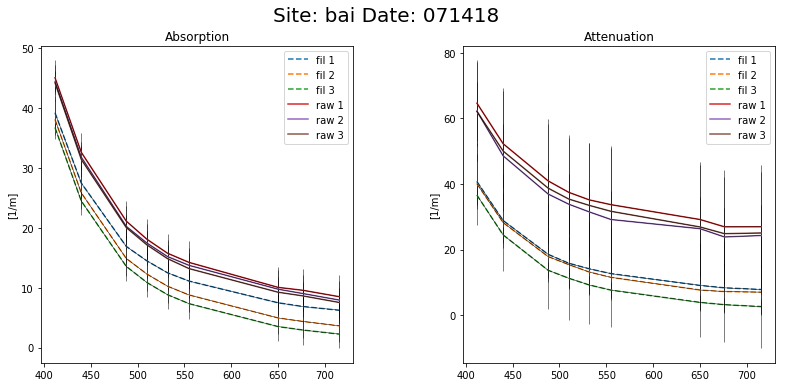

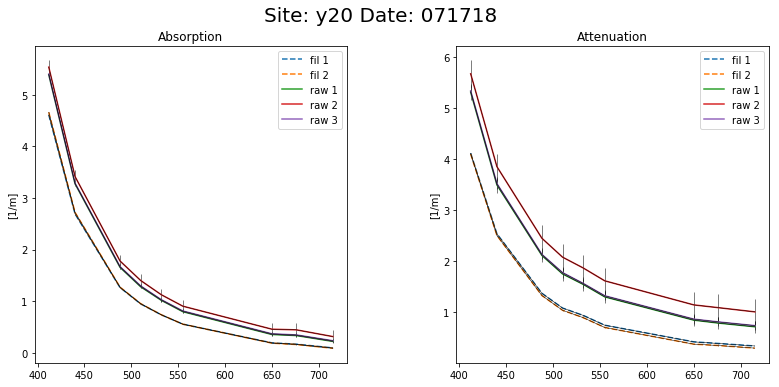

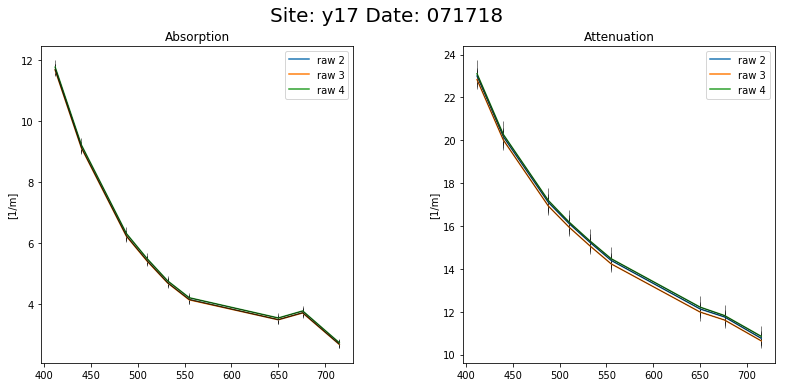

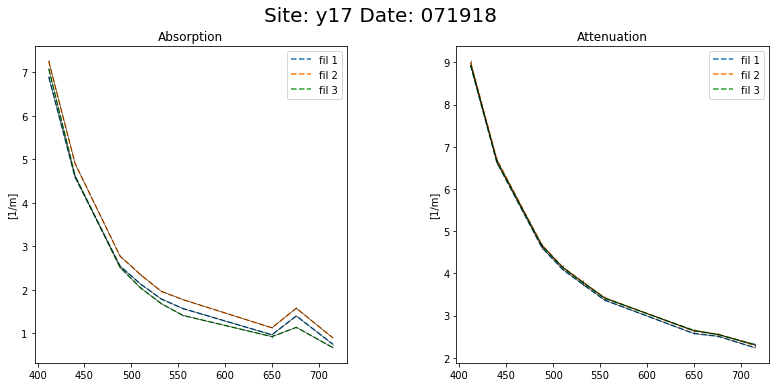

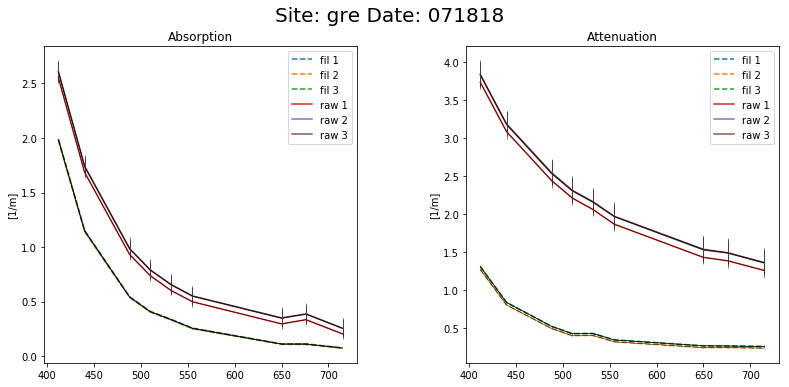

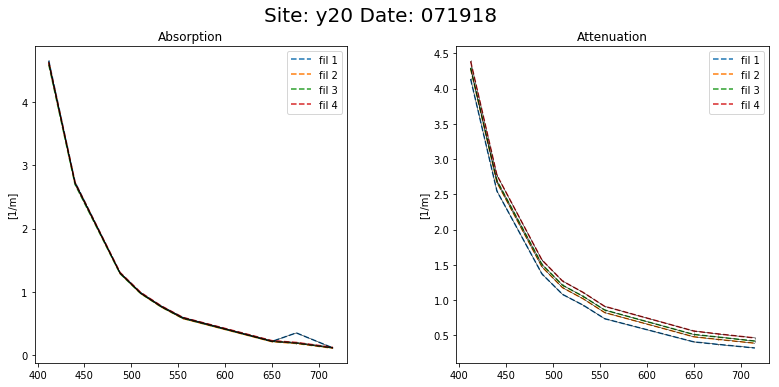

In [14]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict_combinesampletypes:
    Date_all, Site_all = i.split('_')
    plt.subplots(1, 2, figsize=(12, 5.5))
    count = 0
    for j in ['a','c']:
        count += 1
        plt.subplot(1, 2, count)    
        my_plot = plotting_absorption_combinefilandtot(plotting_dict_combinesampletypes[i][j], title=abs_types[j])
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()

#### Put list of unique ids (Site, Date, Sample Type, and Analysis Type) into dictionary with key as combo of Site and Date, so all plots samples taken at the same site and date but of different sample types and analysis types can be compared in a grid

In [91]:
plotting_dict = {}
for i in list_of_sampleids:
    Date, Site, Type, Analysis = i.split('_')
    date_site = Date+'_'+Site
    if date_site not in plotting_dict:
        plotting_dict[date_site] = [i]
    else:
        plotting_dict[date_site].append(i)

### Plot separate filtered and unfiltered

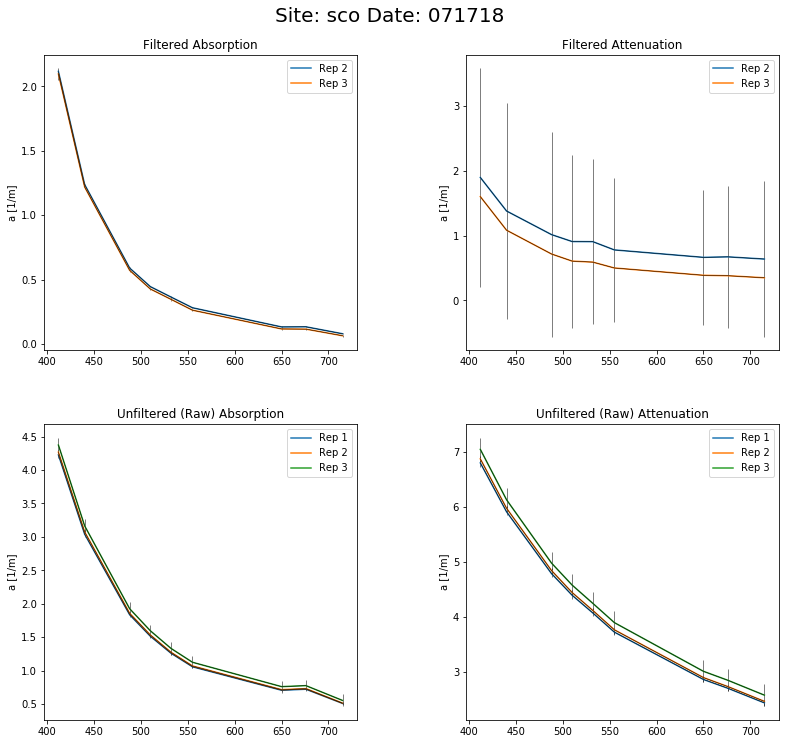

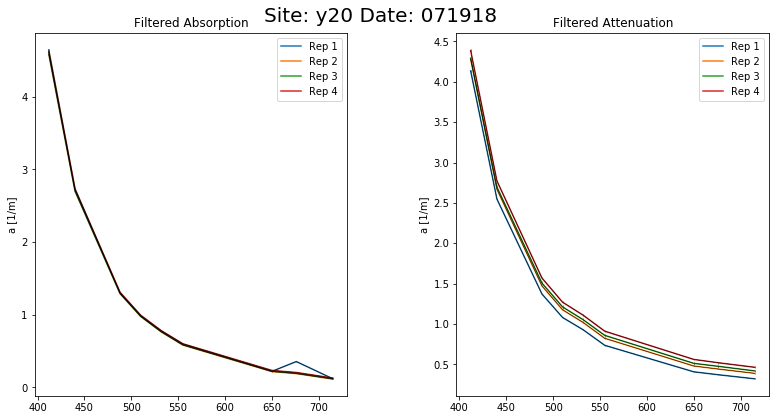

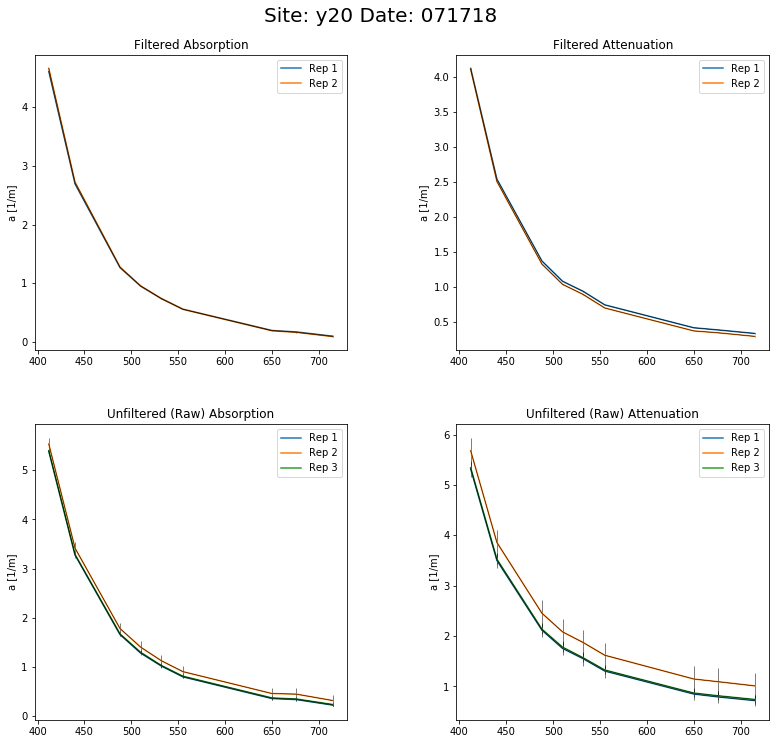

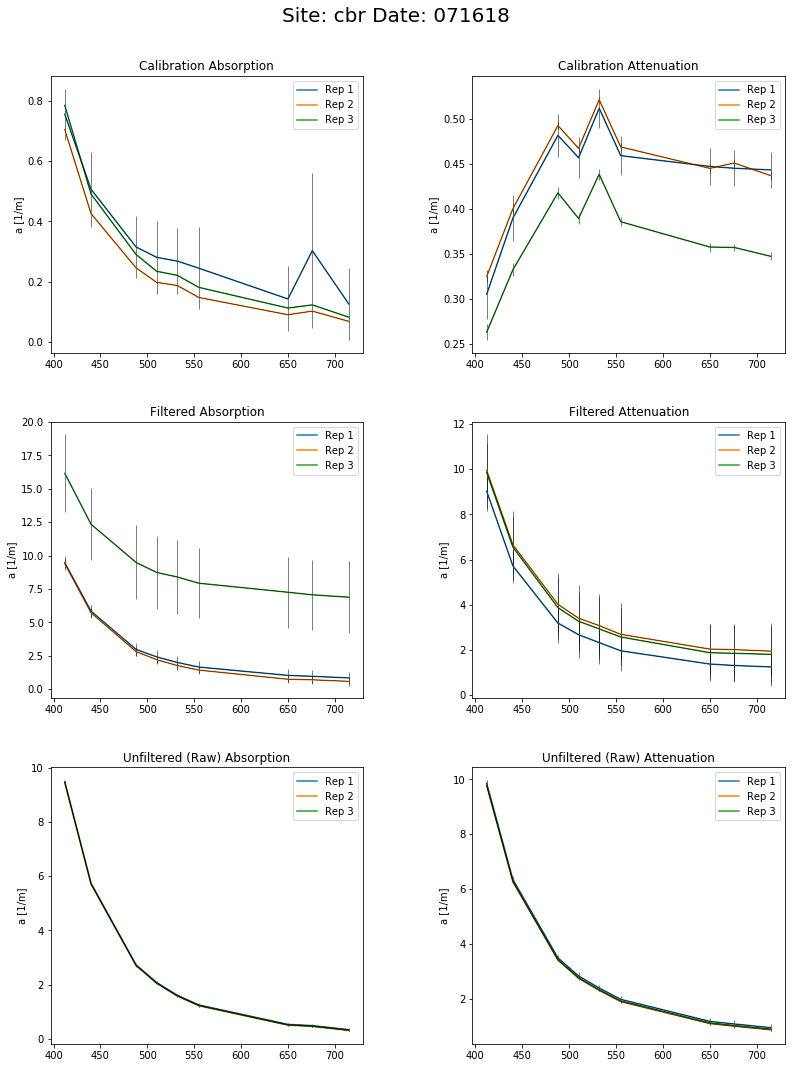

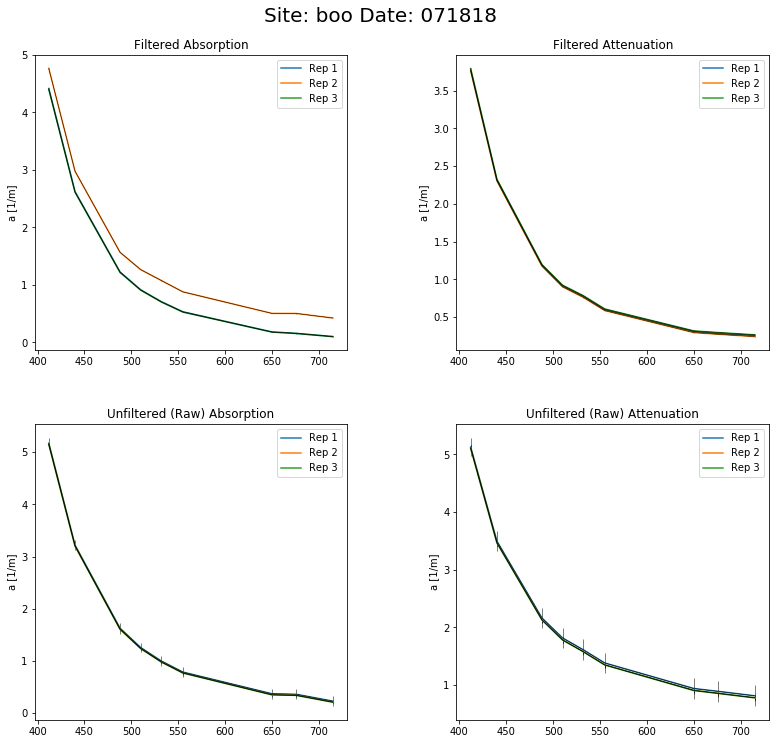

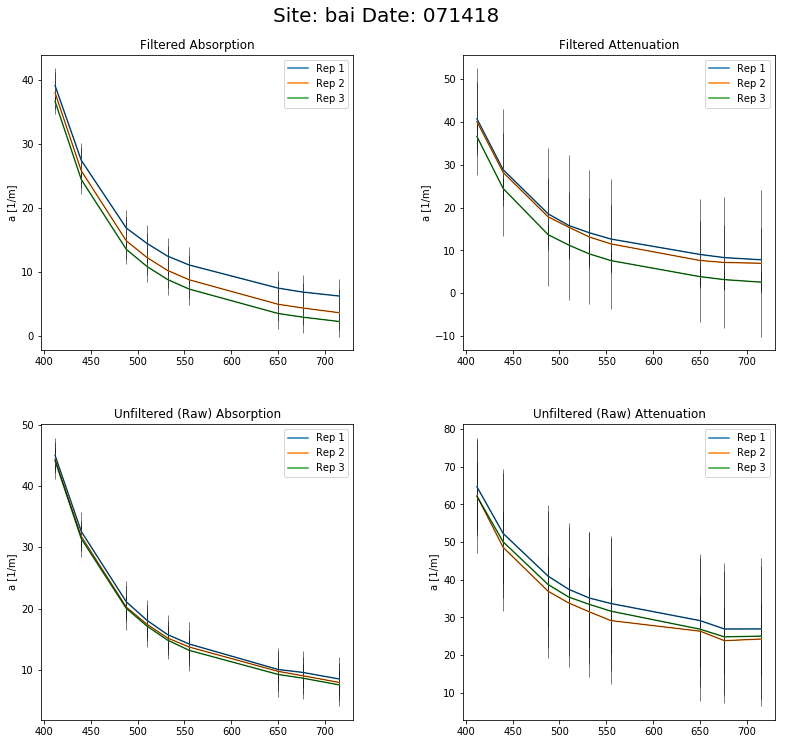

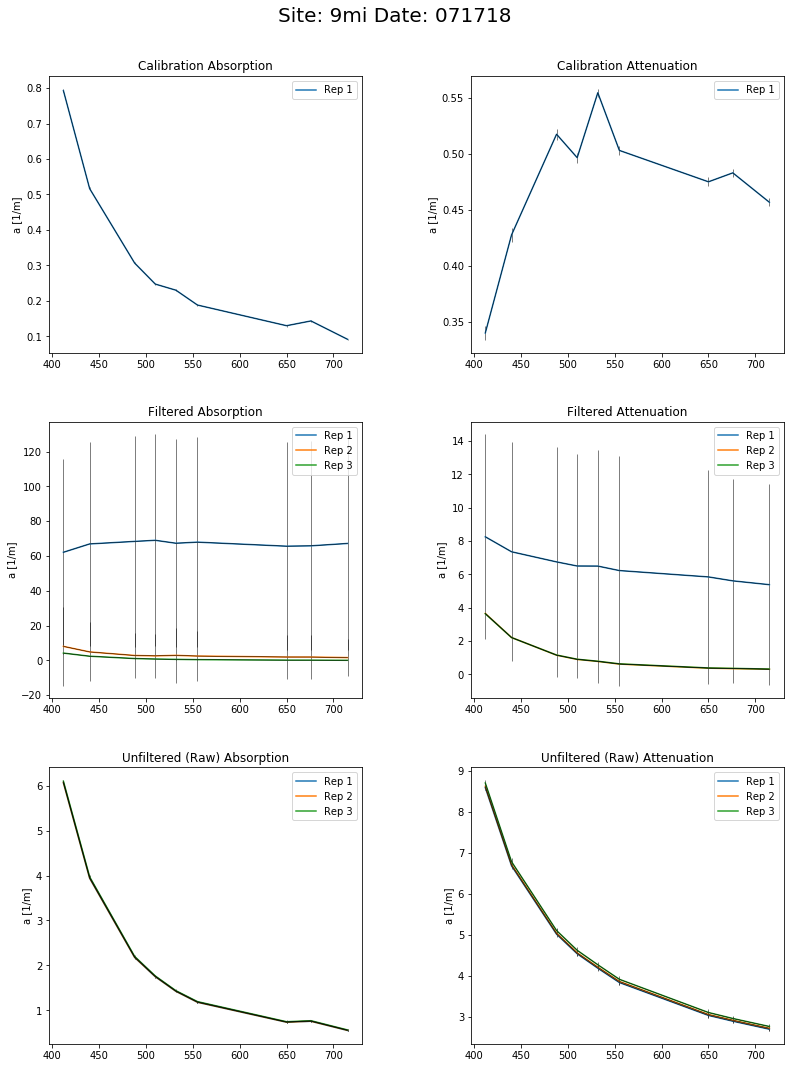

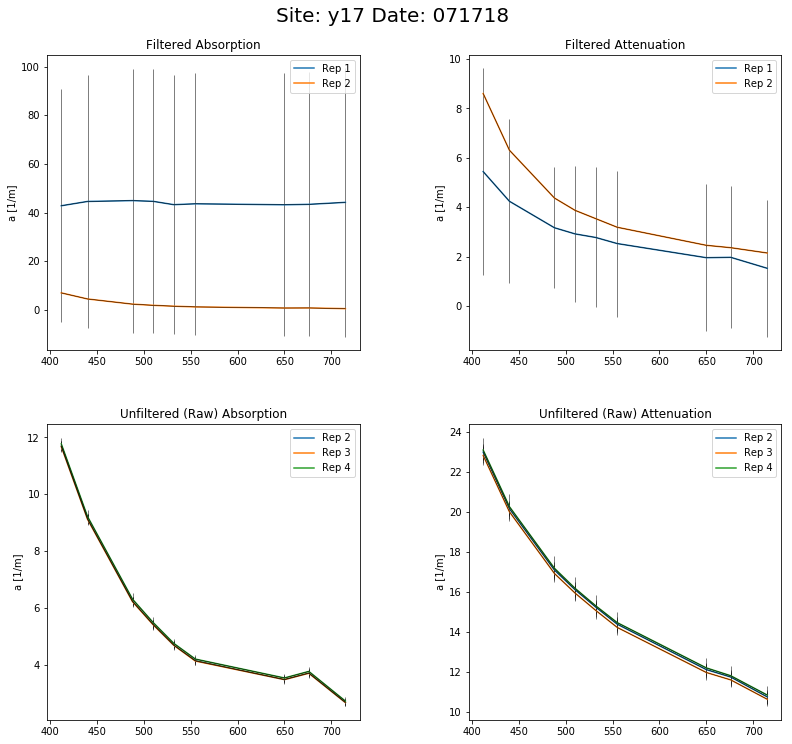

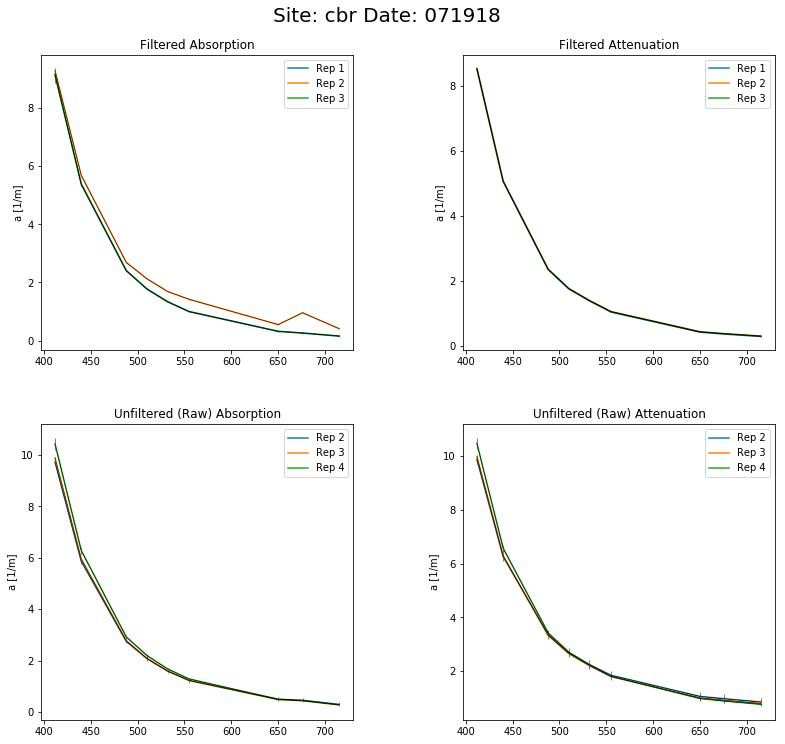

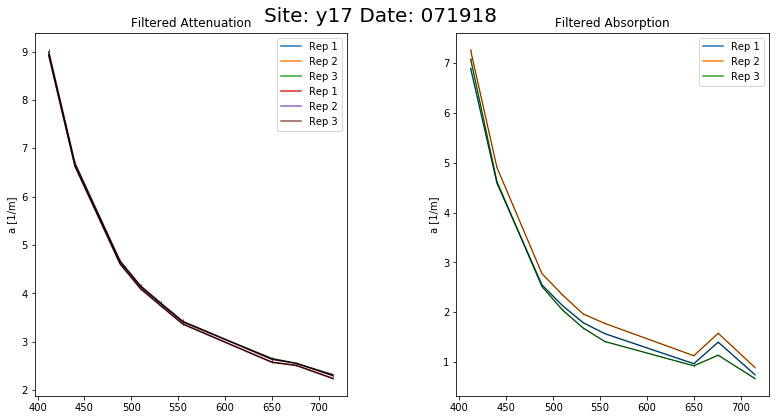

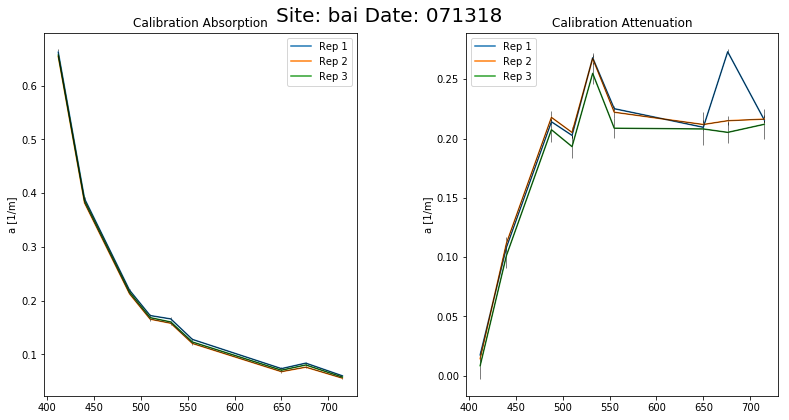

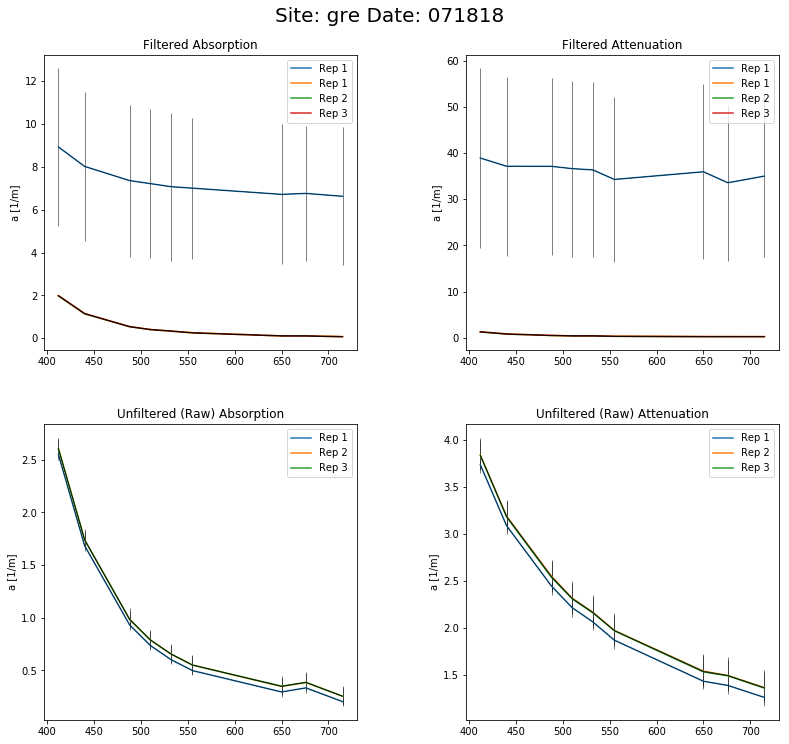

In [124]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict:
    num_of_plots = len(plotting_dict[i])
    num_of_rows = num_of_plots/2
    count = 0
    Date_all, Site_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict[i]:
        count += 1
        Date, Site, Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(dict_of_files[sampleid], title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()

## Average replicates

In [92]:
## Make the new directory for averaged files to go into
if not os.path.exists(averaged_files_location):
    os.makedirs(averaged_files_location)

## Iterate through unique sample ids (combo of site, date, sample type (raw, etc), and analysis type (a or c))
## Sample ids are keys of dictionary made earlier; entries are lists of files that are replicates of that unique combo
for sampleid in dict_of_files:
    if 'All_Calibrations' in sampleid:
        averages_filename = sampleid + '_average.csv'
    else:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = dict_of_files[sampleid][0].split('/')[-1].split('.')[0].split('_')
        averages_filename = '_'.join([Sensor, Date, Site, Sample_Type, Abs_Type,'average.csv'])
    averaged_file = average_replicates(dict_of_files[sampleid])
    outputdir = averaged_files_location + '/' + averages_filename
    averaged_file.to_csv(outputdir, sep='\t')   

## Plot average replicates

In [131]:
def create_dict_w_listentry(dictionary, key, entry):
    if key not in dictionary:
        dictionary[key] = [entry]
    else:
        dictionary[key].append(entry)

In [147]:
def plotting_absorption_2(list_of_files, title='Title'):
    j = 0
    x = []
    y = []
    labels_list = []
    for filename in range(len(list_of_files)):   
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            Sensor, Date, Site, Sample_Type, Abs_Type, eh= list_of_files[filename].split('/')[-1].split('.')[0].split('_')
            repname = 'Rep '+Rep
            date_site = Site+' '+Date
            labels_list.append(date_site)
            plt.plot('wl','mean',data=df,label=date_site)
            plt.scatter('wl', 'mean', data = df)
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
    plt.ylabel('a [1/m]')
    plt.title(title)
    plt.legend(labels_list)
    return plt

In [137]:
dict_of_files = {}

for filename in sorted(glob.glob(averaged_files_location+'/*.csv')):
    #Get file info
    basename = filename.split('/')[-1].split('.')[0]
    if 'cal' in basename or 'Calibrations' in basename:
        continue
    else:
        Sensor, Date, Site, Sample_Type, Abs_Type, filetype= filename.split('/')[-1].split('.')[0].split('_')
        sampletype_abstype = Sample_Type+'_'+Abs_Type
        create_dict_w_listentry(dict_of_files, sampletype_abstype, filename)

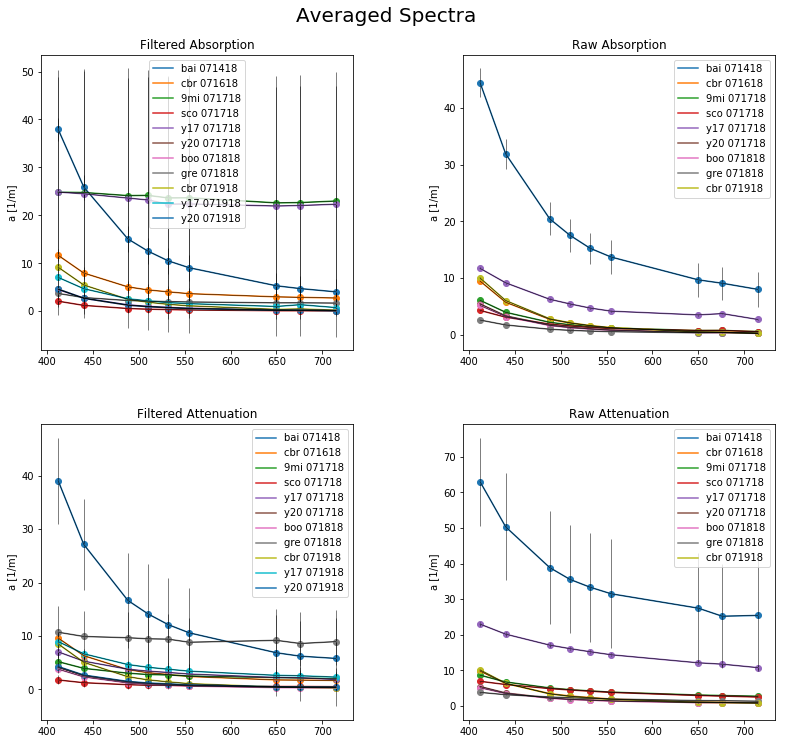

In [151]:
plt.subplots(2, 2, figsize=(12, 11))

plt.subplot(2, 2, 1)
plotting_absorption_2(dict_of_files['fil_a'], title='Filtered Absorption')

plt.subplot(2, 2, 2)
plotting_absorption_2(dict_of_files['raw_a'], title='Raw Absorption')

plt.subplot(2, 2, 3)
plotting_absorption_2(dict_of_files['fil_c'], title='Filtered Attenuation')

plt.subplot(2, 2, 4)
plotting_absorption_2(dict_of_files['raw_c'], title='Raw Attenuation')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
my_plot.suptitle('Averaged Spectra', fontsize=20)
my_plot.show()

## Finding a statistic to check for significant differences between reps....hmm

In [46]:
mydf.to_csv('/Users/Petrichor/Desktop/stat_check.csv')

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



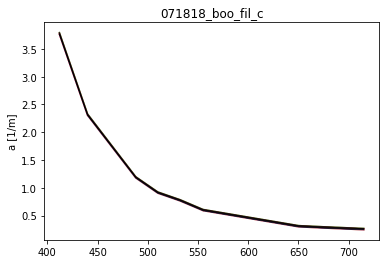

In [42]:
### Generate a dataframe including all reps, with a column denoting the reps
replicates = []
for filename in dict_of_files['071818_boo_fil_c']:
    Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
    df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    df['Rep'] = str(Rep)
    #print df
    replicates.append(df)
mydf = pd.concat(replicates)
mydf['wl'].apply(str)
mydf

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())
plotting_absorption(dict_of_files['071818_boo_fil_c'], title='071818_boo_fil_c').show()

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



In [31]:
for sampleid in dict_of_files:
    replicates = []
    for filename in dict_of_files[sampleid]:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
        df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        df['Rep'] = str(Rep)
        replicates.append(df)
    pd.concat(replicates)
    print replicates

[   Unnamed: 0     wl      mean       std  a_median     a_IQR Rep
0           0  412.0  0.591976  0.192675  0.617685  0.008013   1
1           1  440.0  0.346809  0.071495  0.356950  0.004217   1
2           2  488.0  0.188092  0.049426  0.194855  0.003827   1
3           3  510.0  0.143578  0.048618  0.150565  0.002998   1
4           4  532.0  0.137895  0.058832  0.146140  0.003405   1
5           5  555.0  0.103731  0.053839  0.111425  0.003502   1
6           6  650.0  0.053382  0.049377  0.061460  0.002745   1
7           7  676.0  0.065272  0.048239  0.073180  0.002865   1
8           8  715.0  0.036092  0.039795  0.041720  0.002842   1,    Unnamed: 0     wl      mean       std  a_median    a_IQR Rep
0           0  412.0  0.617012  0.004101   0.61732  0.00548   2
1           1  440.0  0.354836  0.002537   0.35480  0.00348   2
2           2  488.0  0.194446  0.002171   0.19426  0.00292   2
3           3  510.0  0.150545  0.001838   0.15040  0.00236   2
4           4  532.0  0.1459